In [1]:
import gc
import time
import argparse
from fastai.layers import swish

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from fastai.callback.schedule import Learner
from fastai.data.core import DataLoaders
from fastai.losses import L1LossFlat
from fastai.callback.core import Callback
from fastai.callback.tracker import ReduceLROnPlateau, SaveModelCallback

from HW_torch import dataLoads_build, net_parameter_count, hw_layer
from HW_base import evaluate_build, focus_build

In [ ]:
fname               = 'Torch_F25-E128-F60_Linear-LSTM128x4-FC-SELU-FC'
epoch_num_first     = 100
batch_size_first    = 100
epoch_num_second    = 100
batch_size_second   = 500
evaluate_num        = 128
focus_min           = 0.6

In [3]:
class net_test(torch.nn.Module):
    def __init__(self, evaluate_dic_list, **kwargs):
        super(net_test, self).__init__()
        self.hw_layer = hw_layer(evaluate_dic_list)
        self.embedding = torch.nn.Linear(self.hw_layer.channels, 128, bias=False)
        self.lstm = torch.nn.LSTM(128, 128, num_layers=4, bias=False, bidirectional=True, batch_first=True)
        self.fc1 = torch.nn.Linear(128*2, 32, bias=False)
        self.selu = nn.SELU()
        self.fc2 = torch.nn.Linear(32, 1, bias=True)
    def forward(self, x):
        x = self.hw_layer(x)
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)
        return x

In [4]:
data_train_df = pd.read_csv('./Database/train.csv')
data_test_df = pd.read_csv('./Database/test.csv')

In [5]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['u_in_lag'] = df['u_in_lag']*df['breath_id_lagsame']
    df['u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['u_in_lag2'] = df['u_in_lag2']*df['breath_id_lag2same']
    df['u_out_lag2'] = df['u_out'].shift(2).fillna(0)
    df['u_out_lag2'] = df['u_out_lag2']*df['breath_id_lag2same']
    #df['u_in_lag'] = df['u_in'].shift(2).fillna(0)
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['RC'] = df['R']+df['C']
    df = pd.get_dummies(df)
    return df

In [6]:
data_train_df = add_features(data_train_df)
data_test_df = add_features(data_test_df)

In [7]:
drop_columns = ['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2']
x_columns = [col for col in data_train_df.columns if col not in drop_columns]
y_columns = ['pressure']

In [8]:
data_train = data_train_df[x_columns].values.astype(np.float32)
data_train = data_train.reshape(-1, 80, data_train.shape[-1])

target_train = data_train_df[y_columns].values.astype(np.float32)
target_train = target_train.reshape(-1, 80, target_train.shape[-1])

data_test = data_test_df[x_columns].values.astype(np.float32)
data_test = data_test.reshape(-1, 80, data_test.shape[-1])

In [9]:
np.random.seed(121212)
data_idx = np.arange(len(data_train))
np.random.shuffle(data_idx)

train_index = data_idx[:int(len(data_idx)*0.8)]
valid_index = data_idx[int(len(data_idx)*0.8):]

In [10]:
x_train, y_train = data_train[train_index], target_train[train_index]
x_valid, y_valid = data_train[valid_index], target_train[valid_index]
x_test = data_test

In [11]:
del data_train_df
del data_test_df
gc.collect()

0

In [12]:
evaluate_list = [evaluate_build(x_test[..., i], evaluate_num) for i in range(x_test.shape[-1])]
evaluate_focus_list = []
for evaluate in evaluate_list:
    focus = 1 - (len(evaluate) - 1)/10
    if focus < focus_min:
        focus = focus_min
    evaluate_focus = focus_build(evaluate, focus)
    evaluate_focus_list.append(evaluate_focus)

evaluate_num: 127,focus:0.6000: 127it [00:00, 314.60it/s]
evaluate_num:  99,focus:0.6000: 99it [00:00, 289.80it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num: 127,focus:0.6000: 127it [00:00, 166.89it/s]
evaluate_num:  57,focus:0.6000: 57it [00:00, 554.88it/s]
evaluate_num:  80,focus:0.6000: 80it [00:00, 549.32it/s]
evaluate_num: 128,focus:0.6000: 128it [00:00, 156.05it/s]
evaluate_num: 128,focus:0.6000: 128it [00:00, 244.33it/s]
evaluate_num:  97,focus:0.6000: 97it [00:00, 311.22it/s]
evaluate_num:  95,focus:0.6000: 95it [00:00, 302.39it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, 2021.35it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, 2003.97it/s]
evaluate_num

In [13]:
model = net_test(evaluate_focus_list)
print(model)

train_parameter_num, freeze_parameter_num = net_parameter_count(model)
print(train_parameter_num, freeze_parameter_num)

net_test(
  (hw_layer): hw_layer(
    (evaluate_list): ModuleList(
      (0): Embedding(127, 1)
      (1): Embedding(99, 1)
      (2): Embedding(2, 1)
      (3): Embedding(127, 1)
      (4): Embedding(57, 1)
      (5): Embedding(80, 1)
      (6): Embedding(128, 1)
      (7): Embedding(128, 1)
      (8): Embedding(97, 1)
      (9): Embedding(95, 1)
      (10): Embedding(2, 1)
      (11): Embedding(2, 1)
      (12): Embedding(2, 1)
      (13): Embedding(2, 1)
      (14): Embedding(2, 1)
      (15): Embedding(2, 1)
      (16): Embedding(2, 1)
      (17): Embedding(2, 1)
      (18): Embedding(2, 1)
      (19): Embedding(2, 1)
      (20): Embedding(2, 1)
      (21): Embedding(2, 1)
      (22): Embedding(2, 1)
      (23): Embedding(2, 1)
      (24): Embedding(2, 1)
    )
    (focus_list): ModuleList(
      (0): Embedding(127, 1)
      (1): Embedding(99, 1)
      (2): Embedding(2, 1)
      (3): Embedding(127, 1)
      (4): Embedding(57, 1)
      (5): Embedding(80, 1)
      (6): Embedding(128,

epoch,train_loss,valid_loss,time
0,3.560812,3.128743,00:56
1,1.646772,1.585413,00:57
2,1.364705,1.464457,00:58
3,1.255191,1.208895,00:59
4,1.129313,1.165380,00:58
5,1.011415,1.001444,00:58
6,0.928526,0.896122,00:59
7,0.868676,0.810492,01:01
8,0.713176,0.673171,01:01
9,0.612630,0.586440,01:00


Epoch 22: reducing lr to 0.0001969790159464641
Epoch 32: reducing lr to 0.00019443997295306086
Epoch 42: reducing lr to 0.00017290188391582922
Epoch 52: reducing lr to 0.00013875855753067715
Epoch 62: reducing lr to 9.791372646835185e-05
Epoch 72: reducing lr to 5.74297697144166e-05
Epoch 82: reducing lr to 2.4306771044413454e-05
Epoch 92: reducing lr to 4.272013040952909e-06


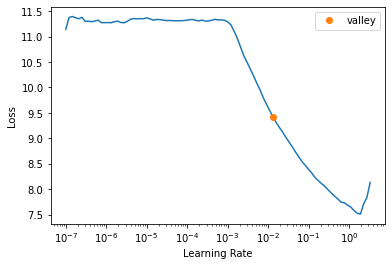

In [14]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_first)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_first, lr_max=2e-3, cbs=ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10))

epoch,train_loss,valid_loss,time
0,0.115342,0.193699,00:45
1,0.115139,0.193679,00:46
2,0.115619,0.193770,00:46
3,0.115542,0.193914,00:44
4,0.116415,0.194187,00:44
5,0.116990,0.194406,00:43
6,0.117266,0.194245,00:43
7,0.117932,0.194867,00:43
8,0.118441,0.194753,00:44
9,0.119960,0.195623,00:45


Better model found at epoch 0 with valid_loss value: 0.19369928538799286.
Better model found at epoch 1 with valid_loss value: 0.19367876648902893.
Epoch 10: reducing lr to 8.591347194839051e-05
Epoch 20: reducing lr to 0.00018807736282679062
Epoch 30: reducing lr to 0.00019686695046697975
Epoch 40: reducing lr to 0.0001783910593204253
Epoch 50: reducing lr to 0.00014636080449597928
Epoch 60: reducing lr to 0.00010631454665746575
Epoch 70: reducing lr to 6.517659400552179e-05
Epoch 80: reducing lr to 3.0060106156435557e-05
Epoch 90: reducing lr to 7.037032825468617e-06


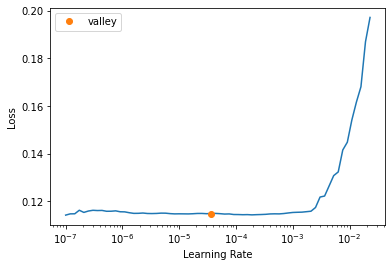

In [15]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_second)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_second, lr_max=2e-3, cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10),
                                                        SaveModelCallback(monitor='valid_loss', fname=f'{fname}_best')])

In [16]:
from HW_torch import torch_valid, torch_predict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

state_dict = torch.load(f'models/{fname}_best.pth')
model.load_state_dict(state_dict)

loss = torch_valid([model.to(device)], L1LossFlat(), (x_train, y_train),  batch_size_second, to_device=device)
valid_loss = torch_valid([model.to(device)], L1LossFlat(), (x_valid, y_valid),  batch_size_second, to_device=device)

print(loss, valid_loss)

0.11466548345552004 0.19352668764129763


In [17]:
predict = torch_predict([model.to(device)], x_test, batch_size_second, to_device=device)
predict = np.reshape(predict, (-1))

prodict: 100% 101/101 [00:12<00:00,  8.01it/s]


In [18]:
df = pd.read_csv('Database/sample_submission.csv', index_col=0)
df['pressure'] = predict

df.to_csv(f'Submission/{fname}.csv')

C:\users\ffly\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


FileNotFoundError: [Errno 2] No such file or directory: 'Submission/Torch_F25-E128-F60_Linear-LSTM256x4-FC-SELU-FC.csv'